In [31]:
import numpy as np
# import matplotlib
# # Show Plot in The Notebook
# matplotlib.use("nbagg")
import matplotlib.pyplot as plt
from ricker import ricker

![gif](1D_3.gif)

In [50]:
#### 
#Travelling wave

#c*(dt/dx)<1
c0 = 2000. #m/s   Velocity
dx = 10 #m   Spatial step
dt = 0.002 #s #Time Step
stab = c0 *(dt/dx) #Stability condition/Courant number
#Check stability condition
if stab < 1:
    print("Stability condition passes:", stab)
else:
    print("Stability condition too large:", stab)


#Initalize values
Nx = 1000 #Number of X points
Nt = 2.5 #Total time length
# X = np.arange(Nx); X*=dx #Spatial vector
time = np.arange(0,Nt+dt,dt) #time array
c = np.zeros(len(time))
c += c0  #Velocity vector

f0 = 70  #Hz Dominant Frequency
t0 = (f0/10) / f0  #Starting time for source

src = -2. * (time-t0) * (f0 ** 2) * (np.exp(-1.0 * (f0 ** 2) * (time-t0) ** 2))  #Source- 1st Gaussian derivative


Stability condition passes: 0.4


In [51]:
#1D Finite difference
#Both 2nd and 4th order accuracy
def finite_2(Nx,c,dx,dt,time,src,reflect,order):
    M = np.zeros([len(time),Nx])    #Storage matrix
    X = np.arange(Nx); X*=dx #Spatial Array
    P = np.zeros(Nx)   #Displacement at current time step
    Pold = np.zeros(Nx)  #Displacement at previous time step
    Pnew = np.zeros(Nx) #Displacement at future time step
    d2px = np.zeros(Nx) #2nd Spatial derivative

    for i in range(len(time)):   #loop through time
        if order == 2:   #2nd order accuracy Spatial
            for j in range(1,Nx-1):
                d2px[j] = (P[j+1] - 2*P[j] +P[j-1]) / dx**2

        if order == 4:  #4th order accuracy Spatial
            for j in range(2,Nx-2):
                d2px[j] = ((-1/12)*P[j+2] +(4/3)* P[j+1] - (5/2)*P[j] +(4/3)*P[j-1] +(-1/12)*P[j-2]) / dx**2

        Pnew = 2* P-Pold + c[i]**2 *dt**2 *d2px    #Calculate next time step
        Pnew[int(order/2)] += (src[i]*dt**2)/ dx   #Introduce the source

        if reflect ==1:
            Pnew[0] = 0; Pnew[300] = 0   ##### Reflecting boundary
        M[i,:] = Pnew        #Put into matrix for animation
        Pold, P = P, Pnew    #Update all displacements

        # if i%200==0:
        #     plt.figure()
        #     plt.plot(Pnew,label=f'{time[i]}')
        #     #plt.xlim(0,300)
        #     plt.legend()
    return M

M1 = finite_2(Nx,c,dx,dt,time,src, 0,2)
M2 = finite_2(Nx,c,dx,dt,time,src,0,4)
M1_ref = finite_2(Nx,c,dx,dt,time,src, 1,2)
M2_ref = finite_2(Nx,c,dx,dt,time,src,1,4)



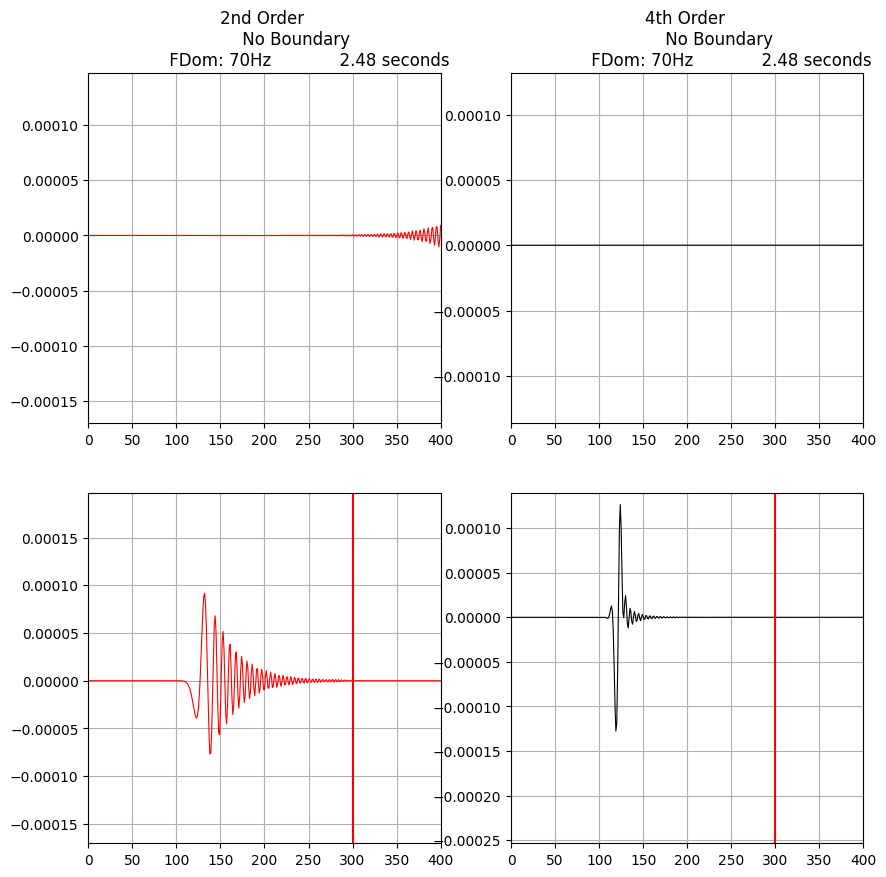

In [52]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter


fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
def update(frame):

    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    ax1.grid()
    ax2.grid()
    ax3.grid()
    ax4.grid()
    ax1.plot(M1[frame,:],'r',linewidth=0.8)
    ax2.plot(M2[frame,:],'k',linewidth=0.8)
    ax3.plot(M1_ref[frame,:],'r',linewidth=0.8)
    ax4.plot(M2_ref[frame,:],'k',linewidth=0.8)
    ax1.set_xlim(0,400)  #reflecting boundary (0,1000)
    ax2.set_xlim(0,400)  #reflecting boundary (0,1000)
    ax3.set_xlim(0,400)  #reflecting boundary (0,1000)
    ax4.set_xlim(0,400)  #reflecting boundary (0,1000)
    ax1.set_ylim(np.min(M1),np.max(M1))
    ax2.set_ylim(np.min(M2),np.max(M2))
    ax3.set_ylim(np.min(M1_ref),np.max(M1_ref))
    ax4.set_ylim(np.min(M2_ref),np.max(M2_ref))
    ax3.vlines(300,np.min(M1_ref),np.max(M1_ref),color='r')
    ax4.vlines(300,np.min(M2_ref),np.max(M2_ref),color='r')
    ax1.set_title(f'2nd Order \n \
            No Boundary \n \
                FDom: {f0}Hz \
            {round(frame*dt,2)} seconds')
    ax2.set_title(f'4th Order \n \
            No Boundary \n \
                FDom: {f0}Hz \
            {round(frame*dt,2)} seconds')

ani = animation.FuncAnimation(fig,update, frames = np.arange(0,len(time),40),interval=50) #40
ani.save('1D_3.gif', writer = 'pillow', fps = 3) #3

plt.show()

In [9]:
#####Pseudo spectral method for spatial terms and calculate error and plot error


c0 = 2000. #m/s   Velocity
dx = 1 #m   Spatial step 10
#dt = 0.002 #s #Time Step
stability = 0.2
dt = (stability/c0)*dx

#Initalize values
Nx = 1000 #Number of X points
Nt = 2.5 #Total time length
# X = np.arange(Nx); X*=dx #Spatial vector
time = np.arange(0,Nt+dt,dt) #time array
c = np.zeros(len(time))
c += c0  #Velocity vector

f0 = 70  #Hz Dominant Frequency
t0 = (f0/10) / f0  #Starting time for source


(25001,)


In [3]:

x0 = np.pi
def fourier_derivative(f,dx):
    Nx = int(len(f))
    kmax = np.pi/dx
    dk = kmax/(Nx/2)
    k = np.arange(float(Nx))
    k[:Nx//2] *= dk
    k[Nx//2:] -= kmax

    ff = 1j*k *np.fft.fft(f)
    df = np.real(np.fft.ifft(ff))
    df = (df-min(df))/ (max(df)- min(df))
    return df


def fourier_derivative_2nd(f,dx):
    Nx = int(len(f))
    kmax = np.pi/dx
    dk = kmax/(Nx/2)
    k = np.arange(float(Nx))
    k[:Nx//2] *= dk
    k[Nx//2:] -= kmax

    ff = (1j*k)**2 *np.fft.fft(f)
    df = np.real(np.fft.ifft(ff))
    #df = (df-min(df))/ (max(df)- min(df))
    return df


# x = np.linspace(2*np.pi/Nx,2*np.pi,Nx)
# dx = x[1] - x[0]
# sigma = 0.5
# f = np.exp(-1/sigma **2 * (x-x0)**2)

# df = fourier_derivative_2nd(f,dx)
# len(x)

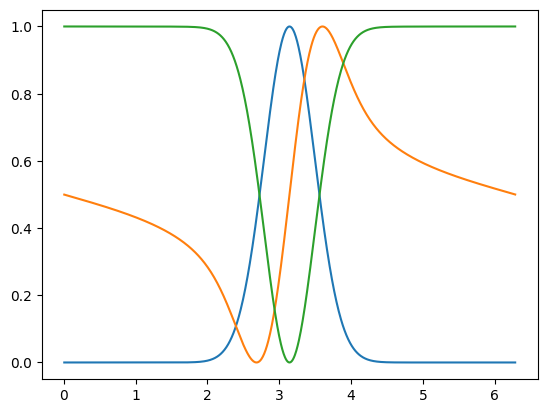

In [13]:
#####
first = fourier_derivative(f,dx)
second = fourier_derivative_2nd(f,dx)
plt.plot(x,f)
plt.plot(x,first)
plt.plot(x,second)


In [26]:
Nt = 3500 # Num of time steps
c = 343
eps = 0.2
isnap = 50 # snapshot freq
isx = 1250 #Source location
f0 = 60. # freq
Nx = 2024 #x gridpoints

p = np.zeros(Nx); pnew = np.zeros(Nx); pold = np.zeros(Nx); d2px = np.zeros(Nx);
ap = np.zeros(Nx); apnew = np.zeros(Nx); apold = np.zeros(Nx); ad2px = np.zeros(Nx);

dx = 1250./(Nx-1)  #Space increment
x = np.arange(0,Nx)*dx
dt = (eps*dx)/c

In [40]:
#Source time
t = np.arange(1,Nt+1)*dt #time axis
T0 = 1./f0
tmp = ricker(f = f0,dt=dt,peak_loc=T0)
tmp = np.diff(tmp)
src = np.zeros(Nt)
src[0:np.size(tmp)] = tmp
lam = c*T0

#Spatial source
sigma = 2*dx
x0 = x[isx-1]
sg = np.exp(-1/sigma**2 * (x-x0)**2)
sg = sg/np.max(sg) ####np.amax
plt.plot(tmp);


<IPython.core.display.Javascript object>

In [28]:
for n in range(Nt):

    ad2px = fourier_derivative_2nd(ap, dx)
    apnew = 2* ap - apold +c**2 * dt**2 * ad2px
    apnew += sg*src[n]*dt**2
    apold, ap = ap, apnew
    ap[1] = 0; ap[Nx-1] = 0 #Free boundary conditions
    if n% 1000==0:
        print(np.max(ad2px))

0.0
0.0
0.0
0.0


In [23]:
# Initialize animated plot
# ---------------------------------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(12,7))  
line1 = ax1.plot(x[isx:], ap[isx:], 'k', lw=1.5, label='FD-3pt')
line2 = ax2.plot(x[isx:], ap[isx:], 'r', lw=1.5, label='FD-5pt')
line3 = ax3.plot(x[isx:], ap[isx:], 'b', lw=1.5, label='Fourier')
ax1.axis([isx*dx, Nx*dx, -6E-7, 6E-7]); ax3.set_xlabel('x [m]')
ax1.legend(loc=4)  
ax2.legend(loc=4) 
ax3.legend(loc=4)

plt.ion()   # set interective mode
plt.show()

for n in range(Nt):

    ad2px = fourier_derivative_2nd(ap, dx)
    apnew = 2* ap - apold +c**2 * dt**2 * ad2px
    apnew += sg*src[n]*dt**2
    apold, ap = ap, apnew
    ap[1] = 0; ap[Nx-1] = 0 #Free boundary conditions

    # --------------------------------------   
    # Animation plot. Display solution
    if not n % isnap: 
        for l in line1:
            l.remove()
            del l               
        for l in line2:
            l.remove()
            del l
        for l in line3:
            l.remove()
            del l
            
        # -------------------------------------- 
        # Display lines
        line1 = ax1.plot(x[isx:], ap[isx:], 'k', lw=1.5)
        line2 = ax2.plot(x[isx:], ap[isx:], 'r', lw=1.5)
        line3 = ax3.plot(x[isx:], ap[isx:], 'b', lw=1.5)
        plt.gcf().canvas.draw()


<IPython.core.display.Javascript object>